## Assignment 2 - RBM
### Author: Luca Palumbo, 639750


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
import struct
from sklearn.metrics import f1_score
from array import array

To get started, I download the MNIST dataset:

In [ ]:
dataset_path = "./dataset"
if not os.path.exists(dataset_path):
  !mkdir dataset
  !curl -L -o ./dataset/archive.zip  https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset
  !unzip ./dataset/archive -d ./dataset
  !rm ./dataset/archive.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.0M  100 22.0M    0     0  45.8M      0 --:--:-- --:--:-- --:--:-- 45.8M
Archive:  ./dataset/archive.zip
  inflating: ./dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: ./dataset/t10k-images.idx3-ubyte  
  inflating: ./dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: ./dataset/t10k-labels.idx1-ubyte  
  inflating: ./dataset/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: ./dataset/train-images.idx3-ubyte  
  inflating: ./dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: ./dataset/train-labels.idx1-ubyte  


So i define a `MnistDataloader` class following the directives linked in the dataset webpage. We can use the `load_data` to get the training data, training labels, test data and test label as numpy array.

In [ ]:

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        x_train = np.array(x_train) / 255
        y_train = np.array(y_train)
        x_test = np.array(x_test) / 255
        y_test = np.array(y_test)
        return (x_train, y_train),(x_test, y_test)


I have defined simple functions to flatten a matrix, reshape a vector into a matrix (the inverse operation), and plot images (matrices).

In [ ]:
def show_image(image, title_text = ""):
    plt.figure(figsize=(5,5))
    plt.imshow(image, cmap=plt.cm.gray)
    if (title_text != ''):
        plt.title(title_text, fontsize = 15)
    plt.show()

def linearize(matrix):
    linearized = matrix.ravel()
    return linearized

def to_matrix(vec):
    l = int(len(vec) ** 0.5)
    matrix = np.array([vec[i*l : (i+1)*l] for i in range(l)])
    return matrix

The following lines of code import the dataset.


In [ ]:
input_path = './dataset'
training_images_filepath = os.path.join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = os.path.join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = os.path.join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

Let's visualize an element of the dataset:

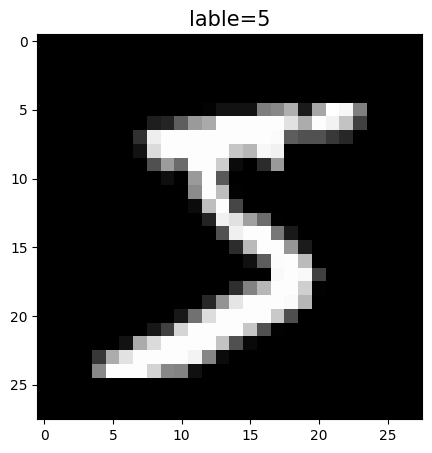

In [ ]:
d, l = x_train[0], y_train[0]
show_image(d, f"lable={l}")

In the following I defined the RBM class. It has a
- constructor that get the number of neuron in the visible and hidden layer and the learning rate and initialize the parameter of the model
- a sample function that get a vector of probabilities and sample 0 or 1
- the `visible_to_hidden` and `hidden_to_visible` functions that sample the hidden/visible layer given the visible/hidden neurons
- the sigmoid function
- the train function that implement the CD-k algorithm. It accept the data, the number of epochs, the batch size and the k parameter

In [ ]:
class RBM:
    def __init__(self, num_visible, num_hidden, lr = 0.1):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = np.random.randn(num_visible, num_hidden) * 0.1
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)
        self.lr = lr

    def __call__(self,visible):
        return self.visible_to_hidden(visible)

    def sample(self, probs):
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def visible_to_hidden(self, visible):
        h_probs = self.sigmoid(np.dot(visible, self.weights) + self.hidden_bias)
        h_states = self.sample(h_probs)
        return h_probs, h_states

    def hidden_to_visible(self, hidden):
        v_probs = self.sigmoid(np.dot(hidden, self.weights.T) + self.visible_bias)
        v_states = self.sample(v_probs)
        return v_probs, v_states

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(self, data_og, k=1, epochs=1, batch_size=100):
      data = data_og.copy()
      num_samples = data.shape[0]
      for epoch in range(epochs):
          np.random.shuffle(data)
          for i in tqdm(range(0, num_samples, batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
              batch = data[i:i+batch_size]
              v0_s = np.stack([linearize(d) for d in batch])
              h0_p, h0_s = self.visible_to_hidden(v0_s)

              hk_s = h0_s
              vk_s = v0_s
              for _ in range(k):
                  vk_p, vk_s = self.hidden_to_visible(hk_s)
                  hk_p, hk_s = self.visible_to_hidden(vk_s)

              wake = np.zeros_like(self.weights)
              dream = np.zeros_like(self.weights)
              for v, h in zip(v0_s, h0_p):
                  wake += np.outer(v, h)
              for v, h in zip(vk_s, hk_p):
                  dream += np.outer(v, h)

              delta_w = (wake - dream) * self.lr / batch_size
              delta_v_bias = np.mean(v0_s - vk_s, axis=0) * self.lr
              delta_h_bias = np.mean(h0_s - hk_s, axis=0) * self.lr

              self.weights += delta_w
              self.visible_bias += delta_v_bias
              self.hidden_bias += delta_h_bias

Next I can just instantiate the object and train it.
- The number of visible neuron is chosen to be $28^2=784$ since this is the number of pixels that compose each image on the dataset
- The number of hidden neuron is an hyper parameter of the model: in this case I choose $7^2 = 49$

For starter I will run the online version of the algorithm (batch size = 1) with 5 epochs.

In [ ]:
v = 28**2
h = 7**2
rbm_online = RBM(v, h)

rbm_online.train(x_train, epochs=5, batch_size=1)

Epoch 5/5: 100%|██████████| 60000/60000 [00:43<00:00, 1370.28it/s]


I can now visualize side by side the image from the dataset, the reconstructed imabe by the Restricted Boltzmann Machine and the hidden sampled encoding learned by the model.

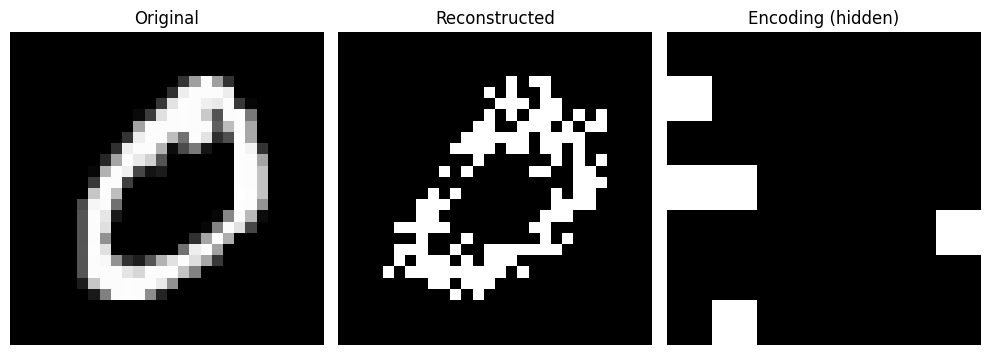

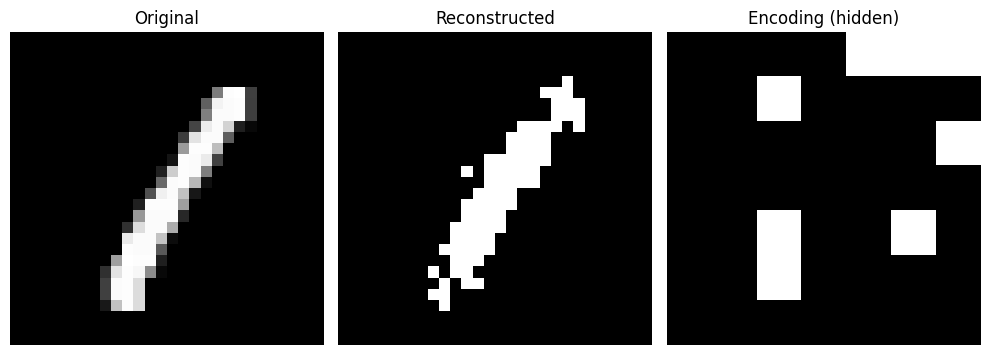

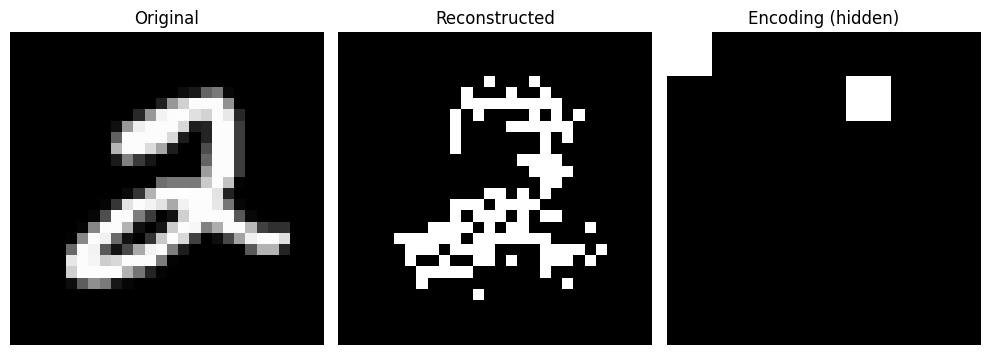

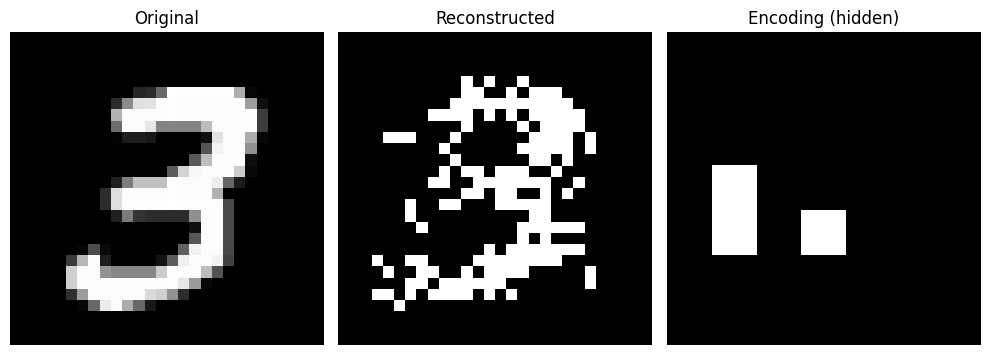

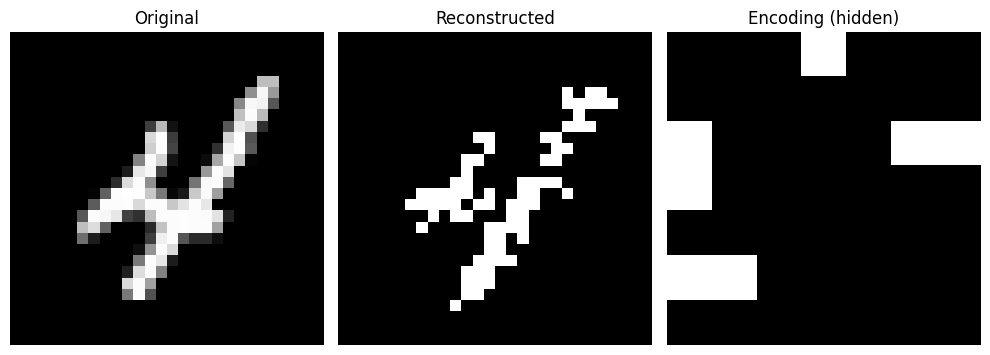

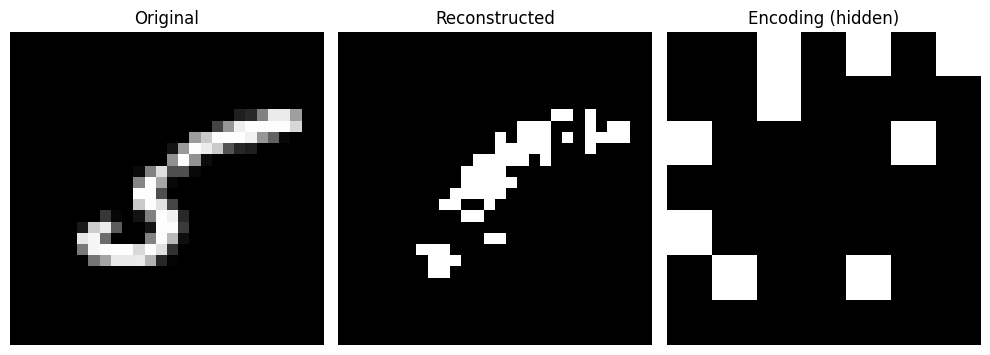

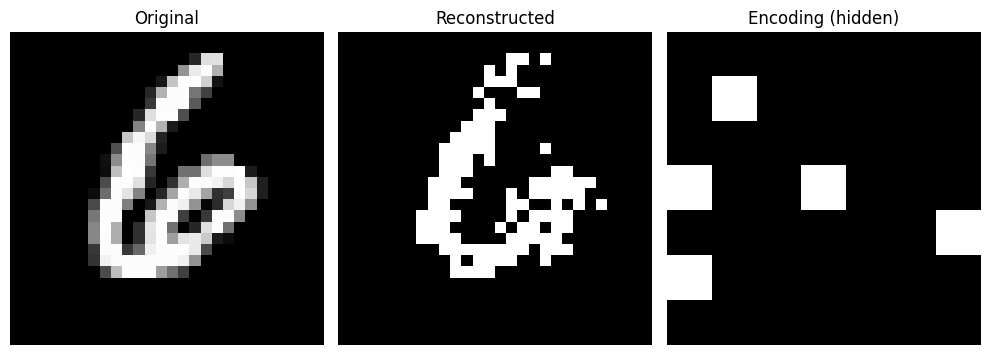

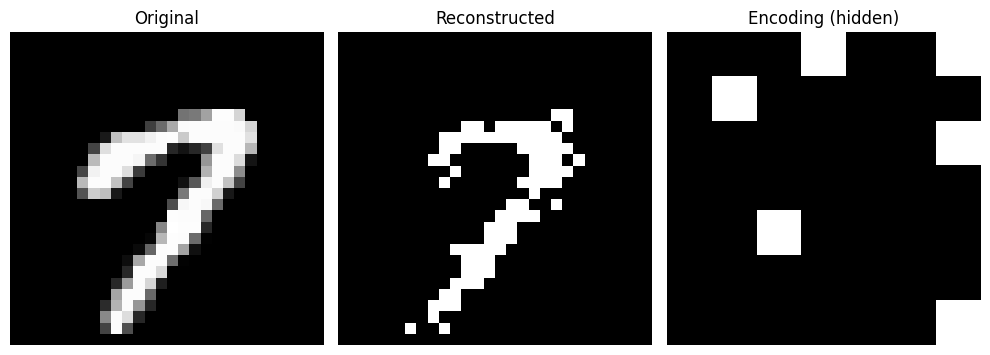

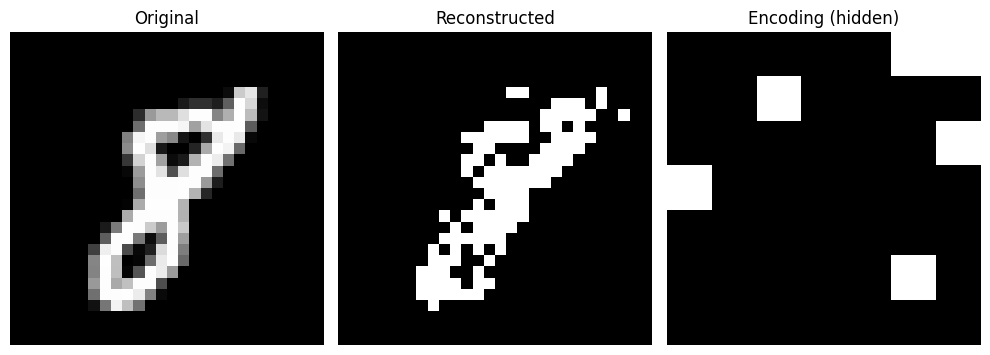

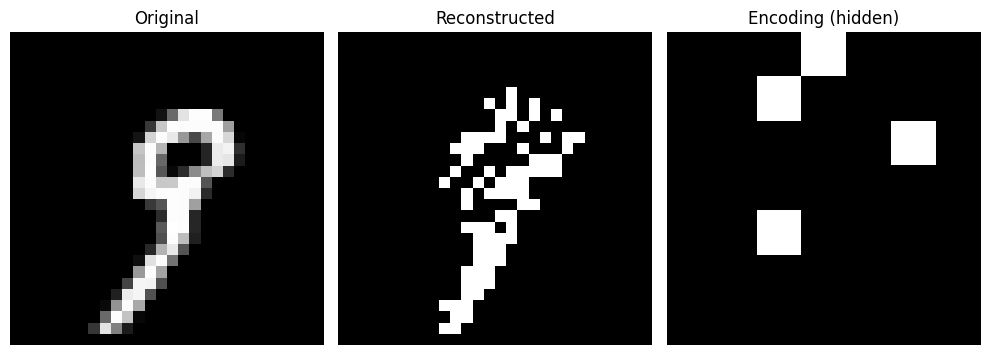

In [ ]:
def show_rbm_encoding(original_image, encoded_vector, reconstructed_vector, img_shape=(28, 28)):
    if original_image.ndim == 1:
        original_image = original_image.reshape(img_shape)
    if reconstructed_vector.ndim == 1:
        reconstructed_image = reconstructed_vector.reshape(img_shape)
    else:
        reconstructed_image = reconstructed_vector
    hidden_size = encoded_vector.shape[0]
    side = int(np.ceil(np.sqrt(hidden_size)))
    padded = np.zeros(side**2)
    padded[:hidden_size] = encoded_vector
    encoded_image = padded.reshape((side, side))

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))

    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(reconstructed_image, cmap='gray')
    axs[1].set_title("Reconstructed")
    axs[1].axis('off')

    axs[2].imshow(encoded_image, cmap='gray')
    axs[2].set_title("Encoding (hidden)")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


number = 0
for i in range(100):
  if y_train[i] == number:
    number+=1
    d = x_train[i]
    v = linearize(d)
    h_prob, h = rbm_online.visible_to_hidden(v)
    v_prob, v_recon = rbm_online.hidden_to_visible(h)
    show_rbm_encoding(d, h, v_recon)
  if number==10:
    break


For understanding how the model works I can plot the weigths connecting the image to each of the hidden neuron. So there are 49 28x28 image plot.
As we can see, in many of them we can recognize clearly digists. When a digit is given as input to the RBM, the hidden neuron that encodes the same digit are more likely to activate.

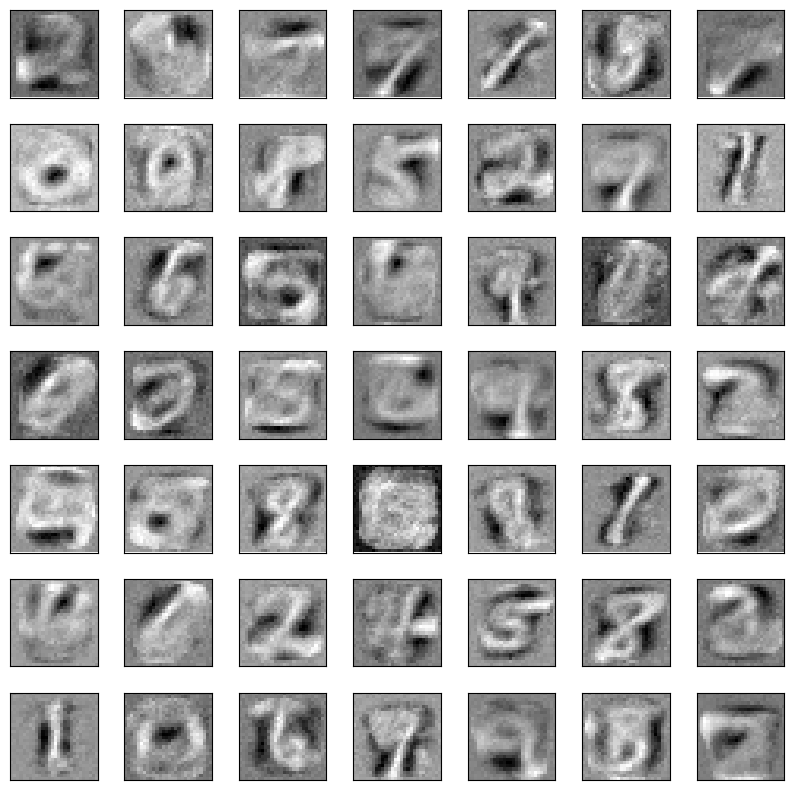

In [ ]:
def plot_rbm_weights(rbm, n=49, img_shape=(28, 28), grid_shape=(7, 7), figsize=(10, 10)):
    def show_image_(matrix, ax):
        ax.imshow(matrix, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i < n:
            w_img = rbm.weights.T[i]
            show_image_(to_matrix(w_img), ax)
        else:
            ax.axis('off')

    plt.show()

plot_rbm_weights(rbm_online, n=49, grid_shape=(7, 7))

Now I will train again the model, but this time using a batch of size 100 and 10 epochs. After that I'll plot the weights again to see the differences.

Epoch 10/10: 100%|██████████| 600/600 [00:21<00:00, 28.08it/s]


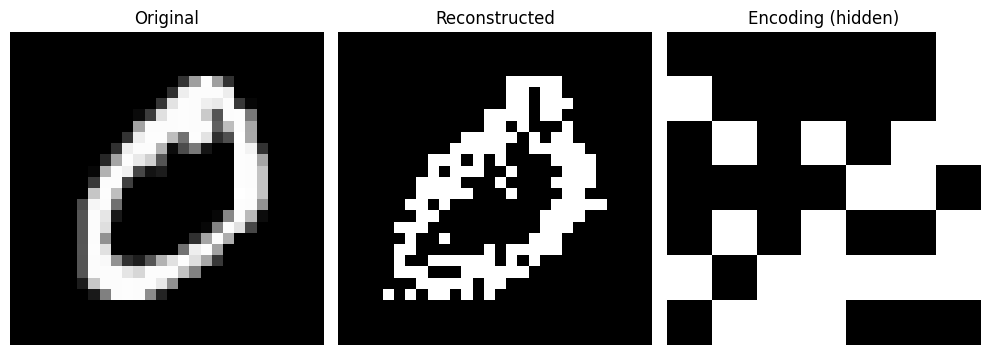

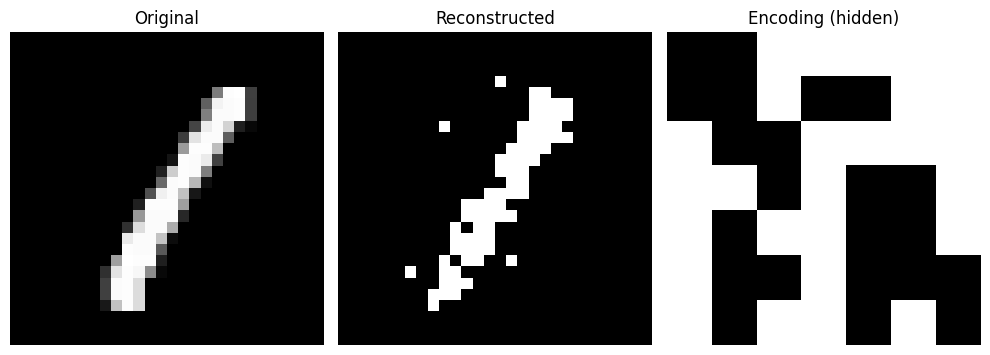

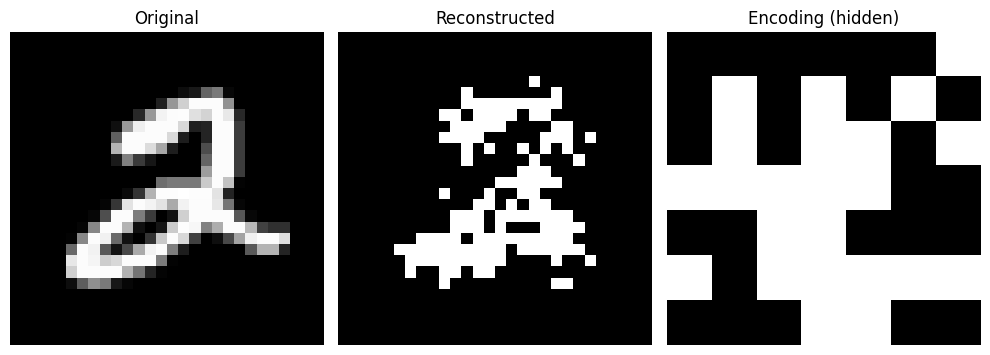

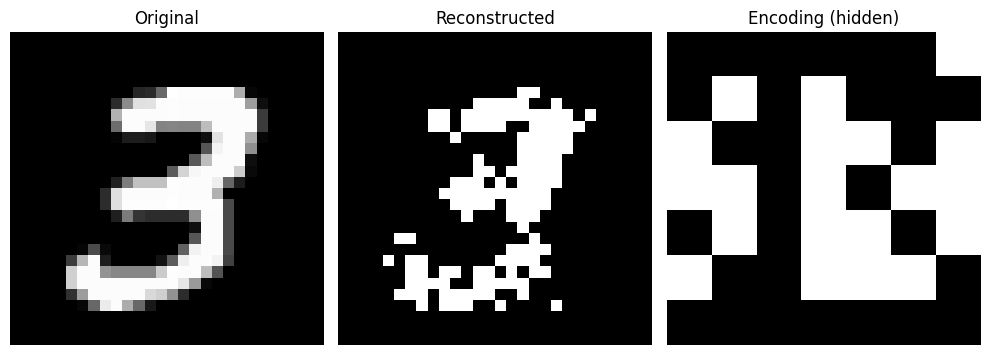

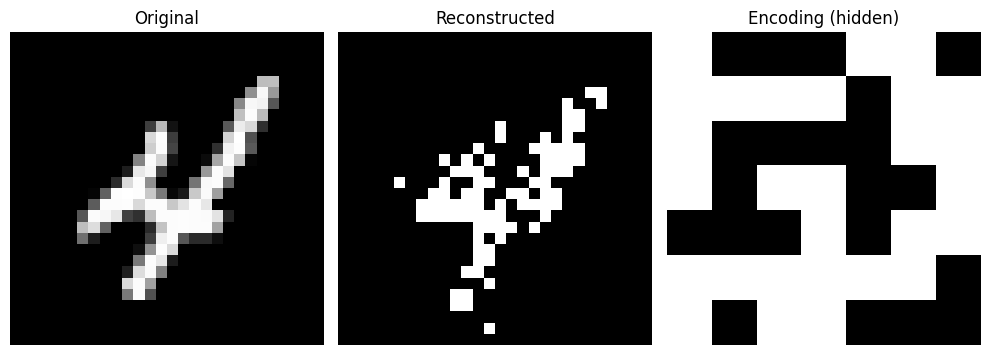

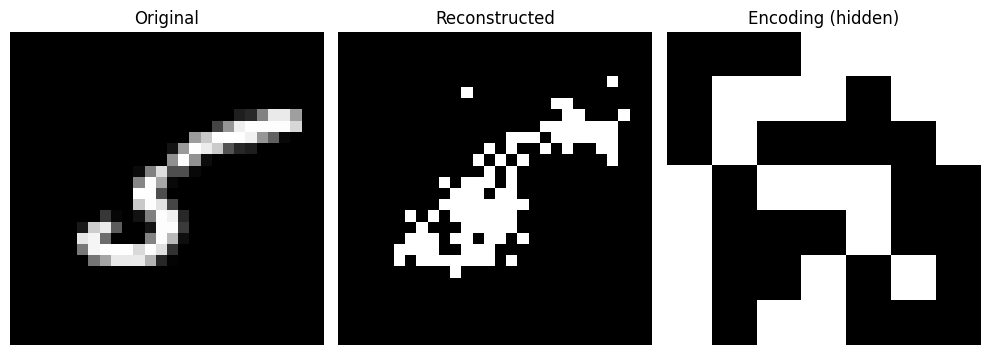

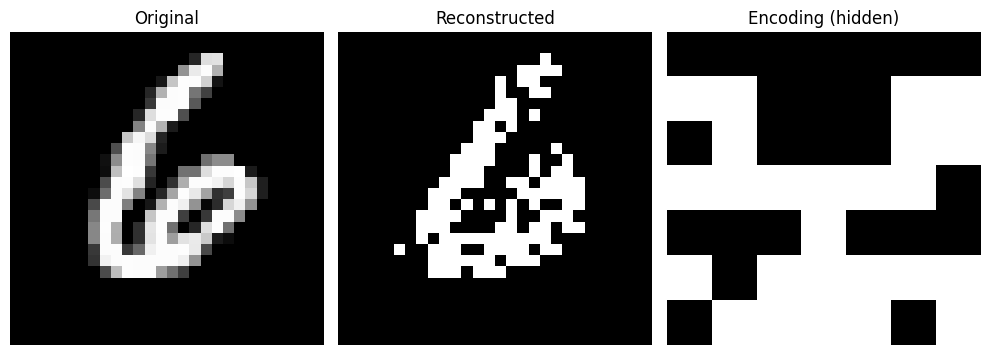

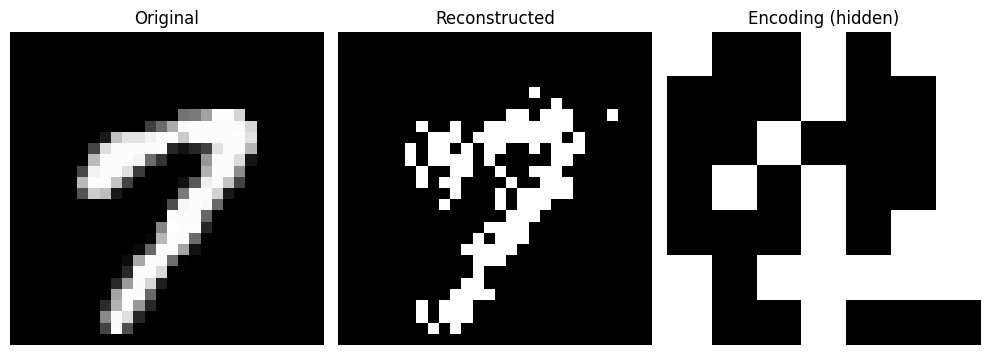

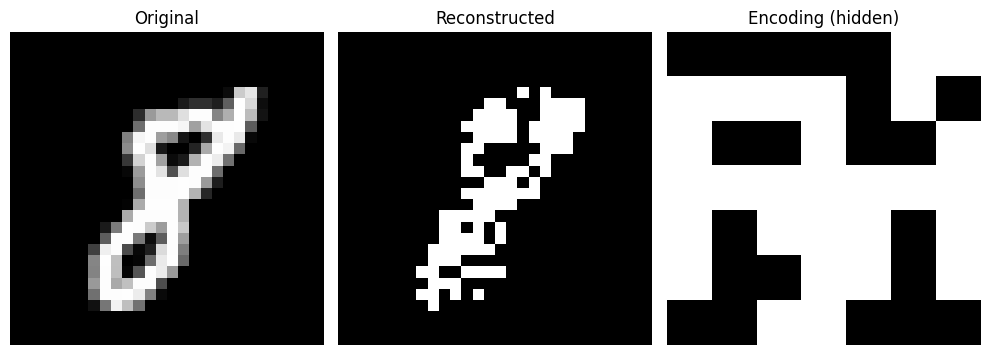

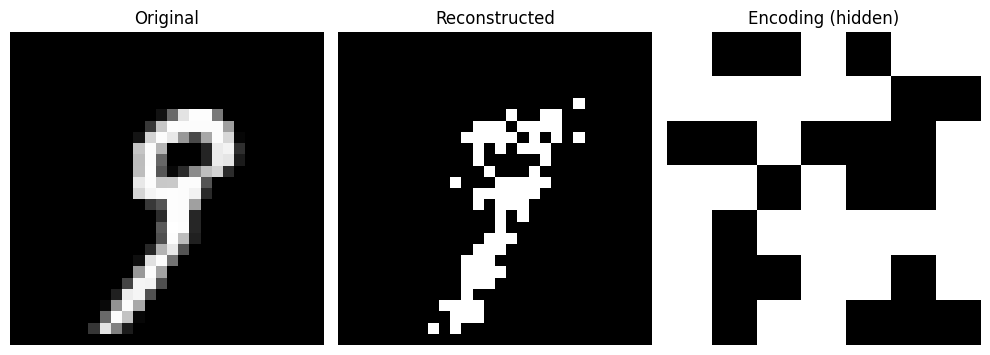

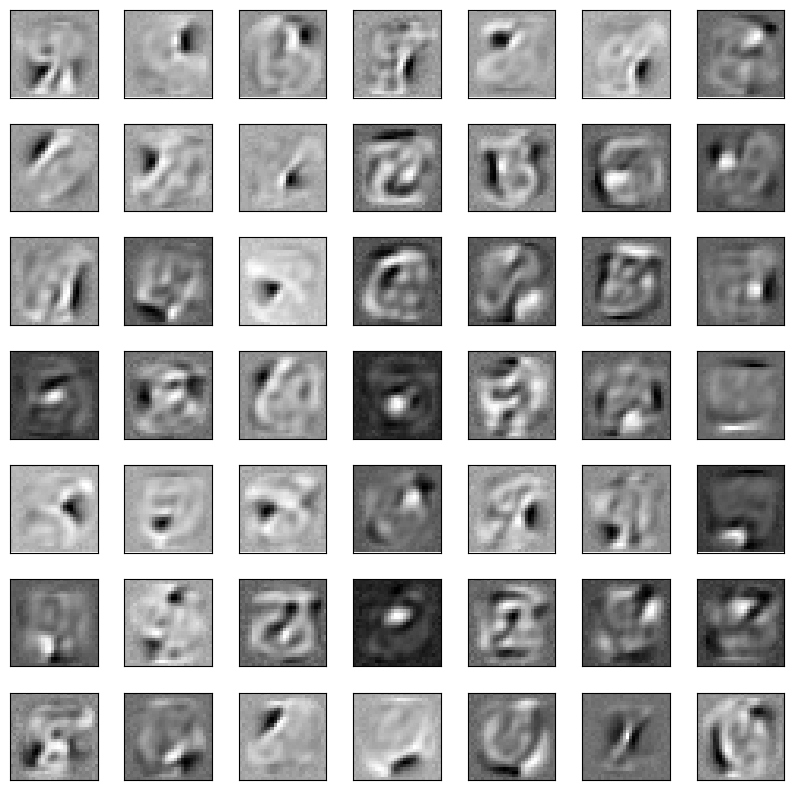

In [ ]:
v = 28**2
h = 7**2
rbm_1 = RBM(v, h)
rbm_1.train(x_train, epochs=10, batch_size=100)

number = 0
for i in range(100):
  if y_train[i] == number:
    number+=1
    d = x_train[i]
    v = linearize(d)
    h_prob, h = rbm_1.visible_to_hidden(v)
    v_prob, v_recon = rbm_1.hidden_to_visible(h)
    show_rbm_encoding(d, h, v_recon)
  if number==10:
    break

plot_rbm_weights(rbm_1, n=49, grid_shape=(7, 7))



As we can observe, when training the RBM using online learning, the learned weights clearly resemble the shapes of the digits. In contrast, when using a larger batch size, this interpretability is mostly lost: the weights appear more abstract and less visually recognizable.

This behavior can be explained by the nature of the weight updates. In online training, each individual sample strongly influences the weights, effectively imprinting features of specific digits onto them. When using larger batches, however, the gradients are averaged over many diverse samples, causing the specific features of individual digits to be smoothed out or diluted.

We now repeat the experiment with the value of the parameter $K=6$ in the learning algorithm, and keeping fixed the number of epochs and batch size. After training, we again plot the weights to analyze how they are affected.

Epoch 10/10: 100%|██████████| 600/600 [00:40<00:00, 14.88it/s]


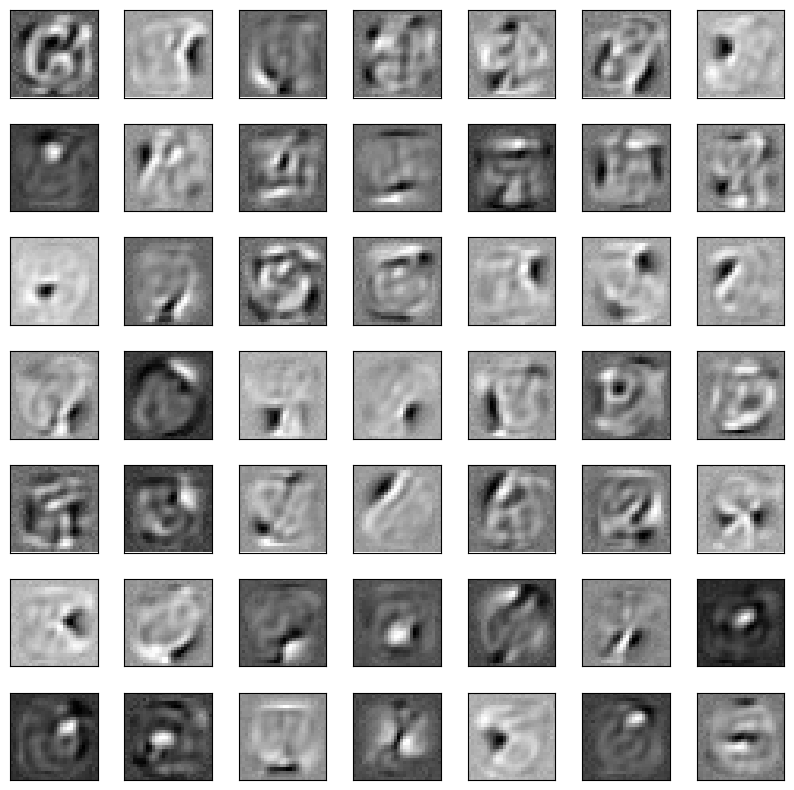

In [ ]:
v = 28**2
h = 7**2
rbm_6 = RBM(v, h)
rbm_6.train(x_train, epochs=10, batch_size=100, k = 6)
plot_rbm_weights(rbm_6, n=49, grid_shape=(7, 7))

In the following, I train an `MLPClassifier` on the hidden representations learned by the three previously trained RBMs (online training with $K=1$, batch training with $K=1$, and batch training with $K=6$).
After training, we compare the classification performance of the models by visualizing their confusion matrices and evaluating their F1 scores.

In [ ]:
x_train_flat = x_train.reshape(60000, 784)
x_test_flat = x_test.reshape(10000, 784)

_, x_embed_online = rbm_online(x_train_flat)
_, x_embed_1 = rbm_1(x_train_flat)
_, x_embed_6 = rbm_6(x_train_flat)

_, x_t_online = rbm_online(x_test_flat)
_, x_t_1 = rbm_1(x_test_flat)
_, x_t_6 = rbm_6(x_test_flat)

def make_mlp():
    return MLPClassifier(hidden_layer_sizes=(64, 32),
                         activation='relu',
                         solver='adam',
                         max_iter=20,
                         random_state=42,
                         verbose=False)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

mlp_online = make_mlp()
mlp_online.fit(x_embed_online, y_train)
y_pred_online = mlp_online.predict(x_t_online)

mlp_1 = make_mlp()
mlp_1.fit(x_embed_1, y_train)
y_pred_1 = mlp_1.predict(x_t_1)

mlp_6 = make_mlp()
mlp_6.fit(x_embed_6, y_train)
y_pred_6 = mlp_6.predict(x_t_6)

accuracy_online = accuracy_score(y_test, y_pred_online)
accuracy_1 = accuracy_score(y_test, y_pred_1)
accuracy_6 = accuracy_score(y_test, y_pred_6)

print(f"Accuracy (online K=1): {accuracy_online:.4f}")
print(f"Accuracy (batch K=1):  {accuracy_1:.4f}")
print(f"Accuracy (batch K=6):  {accuracy_6:.4f}")


Accuracy (online K=1): 0.8918
Accuracy (batch K=1):  0.9320
Accuracy (batch K=6):  0.9391


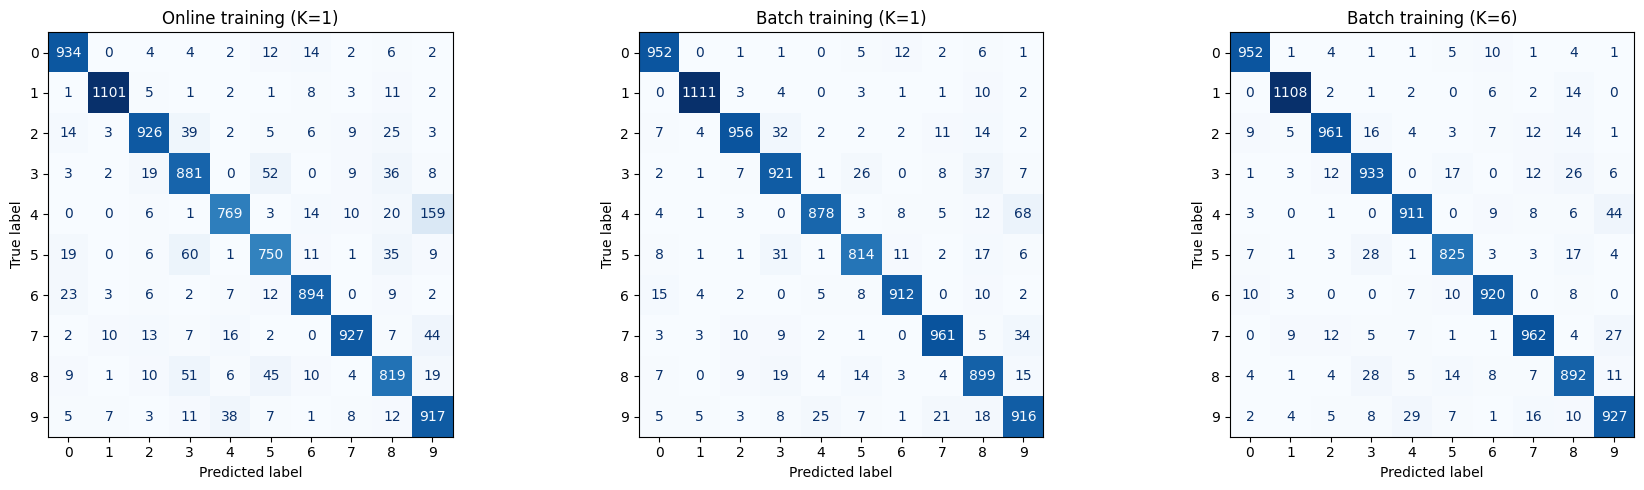

F1-score (macro) - Online (K=1): 0.8904
F1-score (macro) - Batch  (K=1): 0.9314
F1-score (macro) - Batch  (K=6): 0.9386


In [ ]:

cm_online = confusion_matrix(y_test, y_pred_online)
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_6 = confusion_matrix(y_test, y_pred_6)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay(cm_online).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Online training (K=1)")

ConfusionMatrixDisplay(cm_1).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Batch training (K=1)")

ConfusionMatrixDisplay(cm_6).plot(ax=axes[2], cmap='Blues', colorbar=False)
axes[2].set_title("Batch training (K=6)")

plt.tight_layout()
plt.show()

f1_online = f1_score(y_test, y_pred_online, average='macro')
f1_1 = f1_score(y_test, y_pred_1, average='macro')
f1_6 = f1_score(y_test, y_pred_6, average='macro')

print(f"F1-score (macro) - Online (K=1): {f1_online:.4f}")
print(f"F1-score (macro) - Batch  (K=1): {f1_1:.4f}")
print(f"F1-score (macro) - Batch  (K=6): {f1_6:.4f}")

:The accuracy improves steadily from the online version (0.8918) to the batch version with K=1 (0.9320), reaching the best value with K=6 (0.9391).
The same trend is observed for the F1-score (macro), which increases from 0.8904 to  0.9314 and finally to 0.9386. This suggests that batch training help the RBM learn more informative latent features.
On the other hand choosing a higher parameter K do not contribute in enhancing the performace of the model, and slow down the training significantly.